In [2]:
import torch

In [3]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from transformers import WhisperForConditionalGeneration
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

In [4]:
from datasets import Dataset, Audio, load_dataset

In [5]:
from os import walk, rename
from os.path import join, exists

In [6]:
import pandas as pd
import csv
import soundfile as sf

from Levenshtein import distance
from random import choice
from evaluate import load

In [10]:
import matplotlib.pyplot as plt
import librosa.display as ld
import librosa
import numpy as np

# Предобработка данных

При подготовке к выполнению курсовой работы я наткнулся на github репозиторий https://github.com/snakers4/open_stt - открытые speech to text датасеты, распространяющиеся по лицензии CC-BY-NC (то есть бесплатные для обучения). 

Среди всего объема данных более 300 Гб я выбрал раздел asr_public_stories_1 объемом 4 Гб. В нем диктор читает текст сказок (аудиокниги). Аудиоданные хранятся в файлах с расширением .opus, а их текстовая расшифровка хранится в файле с таким же названием с расширением .txt. 

Для правильной загрузки датасета нужно сделать файл metadata.csv, который бы содержал информацию о аудиофайле и его настоящем содержимом. Спарсим данные из папки с помощью модуля `os`

In [103]:
root_folder = r'C:\Users\Denis\Desktop\Kursach\Data\asr_public_stories_1'
walk_generator = walk(root_folder)
walk_generator

<generator object _walk at 0x00000264A2FEAB60>

In [104]:
audio_files = []
text_files = []
for root, dirs, files in walk_generator:
    for filename in files:
        if '.opus' in filename:
            path = join(root, filename)
            audio_files.append(path)
            text_files.append(path.replace('.opus', '.txt'))

In [86]:
len(audio_files), len(text_files)

(46138, 46138)

Видим, что датасет содержит в себе более 46 тысяч аудиозаписей и текстовые расшифровки к ним

In [107]:
audio_files = ['\\'.join(path.split('\\')[-3:]) for path in audio_files]
text_files = ['\\'.join(path.split('\\')[-3:]) for path in text_files]

In [109]:
audio_files[:5], text_files[:5]

(['0\\00\\4242dbd680d3.opus',
  '0\\00\\42cf17b45995.opus',
  '0\\00\\495bfc4a6f79.opus',
  '0\\00\\7acc40962b1b.opus',
  '0\\00\\8ffb80f141ae.opus'],
 ['0\\00\\4242dbd680d3.txt',
  '0\\00\\42cf17b45995.txt',
  '0\\00\\495bfc4a6f79.txt',
  '0\\00\\7acc40962b1b.txt',
  '0\\00\\8ffb80f141ae.txt'])

Теперь воспользуемся обычным методом read() для прочтения всех файлов. Сохраним полученный текст, обработаем вывод

In [71]:
text_files_content = [open(file, mode='r', encoding='utf-8').read() for file in text_files]
text_files_content[:5]

['совершенная технология\n',
 'день слышался ей\n',
 'что яна обложки сборников сказок\n',
 'мышиный чепухи и\n',
 'пересмотреть свои астрофизик\n']

In [74]:
text_files_content = [x.strip() for x in text_files_content] # Уберем лишние пробелы
text_files_content[:5]

['совершенная технология',
 'день слышался ей',
 'что яна обложки сборников сказок',
 'мышиный чепухи и',
 'пересмотреть свои астрофизик']

После того, как относительные пути до файлов и текстовые расшифровки получены, запишем их в файл `metadata.csv`

In [120]:
with open('metadata.csv', 'w', newline='', encoding='utf-8') as file:
    fields = ['file_name', 'transcription']
    write = csv.writer(file)
    write.writerow(fields)
    for path, content in zip(audio_files, text_files_content):
        write.writerow([path, content])

Файл metadata.csv имеет вид `file_name, transcription`

# Визуализация данных

In [2]:
file_path = r'Z:\Code\Uni\ML\Kursach\Data\asr_public_stories_1\5\0b\5c494c66ddf5.opus'

In [3]:
y, sr = librosa.load(file_path)

Выведем визуальное представление аудиосигнала во времени и лог-мел спектрограмму для этой же записи

In [8]:
with open(file_path.replace('.opus', '.txt'), encoding='utf-8') as file:
    print(file.read())

первое что увидел это были белые кресты



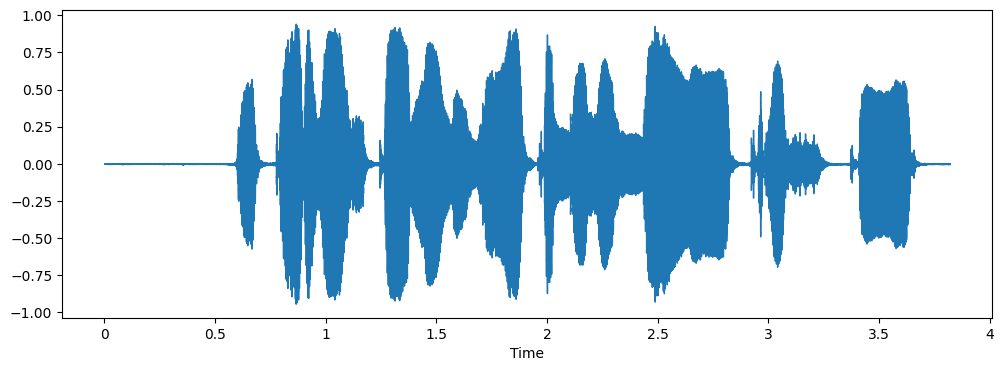

In [5]:
plt.figure(figsize=(12,4))
ld.waveshow(y, sr=sr)
plt.show()

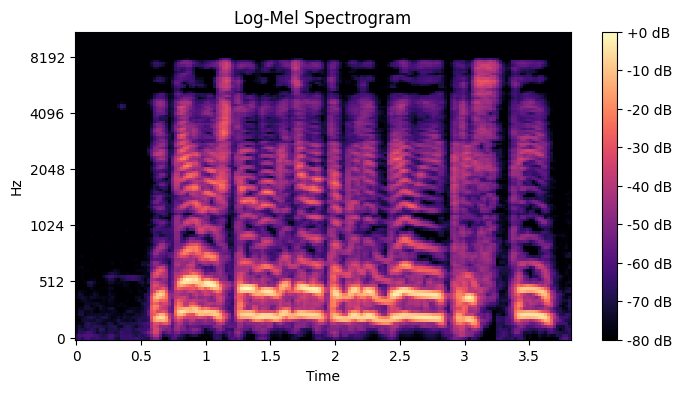

In [11]:
def compute_logmel_spectrogram(y, sr, n_mels=128, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram
 
# Compute log-mel spectrogram
logmel_spectrogram = compute_logmel_spectrogram(y, sr=sr)
# librosa.export(y, format = 'wav')
# Display the log-mel spectrogram
plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

# Разделение данных на обучающую и тестовую выборку

Сформируем датасет с помощью функции `load_dataset`, передав в неё путь до папки с `metadata.csv` и `.opus` файлами

In [7]:
dataset = load_dataset("audiofolder", data_dir=r"Z:\Code\Uni\ML\Kursach\Data\asr_public_stories_1")

Resolving data files:   0%|          | 0/92277 [00:00<?, ?it/s]

In [8]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000)) # Приведем столбец к нужному типу данных

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 46138
    })
})

In [10]:
split = dataset['train'].train_test_split(test_size=0.3)
train = split['train']
test = split['test']

In [11]:
train

Dataset({
    features: ['audio', 'transcription'],
    num_rows: 32296
})

In [12]:
test

Dataset({
    features: ['audio', 'transcription'],
    num_rows: 13842
})

# Определение метрики качества модели

Для определения качества модели распознавания речи используется метрика $WER$ - word error rate. Она рассчитывается на основании расстояния Левинштейна. $WER = \frac{D}{N}$, где D - расстояние Левинштейна, а N - это количество слов в оригинальном слове. 

Чем меньше расстояние левинштейна, тем меньше числитель, тем меньше значение $WER$. Следовательно, чем меньше значение WER, тем лучше.

Существует также метрика $W_{\text{accuracy}} = 1 - WER$. Чем больше метрика точности, тем лучше

Расстояние Левинштайна (Levinstein distance) - это метрика, измерающая разность между двумя последовательностями символов. Разность рассчитывается как количество удалений, замен и вставок, которые необходимы для превращения одной последовательности символов в другую, например:

In [33]:
# Здесь буква w заменена на v и добавлена буква h -> 2
distance("lewenstein", "levenshtein")

2

# Качество предобученной модели

Загрузим модель, подключим вычисления на видеокарте. Создадим pipeline для применения модели

Для чтения opus файлов потребуется установить и импортировать soundfile.

In [13]:
model_id = "openai/whisper-small"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,

    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Протестируем модель на случайном элементе выборки. Посмотрим, какой результат выдала модель и какой результат ожидался:

In [19]:
import random
index = random.randint(1, 1000)
predicted = pipe(train[index]['audio'], generate_kwargs={"language": "russian"})
source = train[index]['transcription']
print(f'Распознано: {predicted["text"]}, сказано: {source}')

C:\Users\Denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\whisper\modeling_whisper.py:694: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Распознано:  и быстро-быстро заморгал окарьями глазами., сказано: быстро быстро заморгала карими глазами


In [29]:
wer_metric = load('wer')

## Проверим качество модели 
Для этого произведем распознавание речи на малом объеме данных (\~700 элементов) и на всей тестовой выборке (~13 тысяч элементов). Результаты запишем в два списка: оригинал и распознанную речь.

Возьмем часть обучающей выборки (~700 элементов) и посчитаем качество модели

In [23]:
test_part = test[::20]

In [24]:
len(test_part['audio'])

693

In [26]:
n = len(test_part['audio'])
references = []
predictions = []
for i in range(n):
    predictions.append(pipe(test_part['audio'][i], generate_kwargs={"language": "russian"}))
    references.append(test_part['transcription'][i])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


In [30]:
predictions_texts = [x['text'] for x in predictions]
predictions_texts[:3]

[' Таких красивых слов не бывает!',
 ' Наивно и уверенно в непоговорительности.',
 ' великолепно говорила, потирай руки.']

In [33]:
wer = wer_metric.compute(references=references, predictions=predictions_texts)
round(wer, 3)

0.598

In [34]:
w_accuracy = 1 - wer
round(w_accuracy, 3)

0.402

На малом объеме данных предобученная модель показала точность ~$40.2\%$. Проверим точность на всей тестовой выборке:

In [93]:
predictions = []
for out in tqdm(pipe(KeyDataset(test, 'audio'), generate_kwargs={"language": "russian"})):
    predictions.append(out['text'])


 28%|██████████████████████▎                                                         | 241/866 [00:14<00:40, 15.59it/s]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.

 72%|█████████████████████████████████████████████████████████▋                      | 624/866 [00:35<00:10, 22.10it/s]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.

 92%|█████████████████████████████████████████████████████████████████████████▉      | 801/866 [00:48<00:03, 17.00it/s]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.

100%|███████████████████████████████████████████████████████████████████████████████▉| 865/86

In [98]:
wer = wer_metric.compute(references=test['transcription'], predictions=predictions)
round(wer, 3)

0.618

In [99]:
w_accuracy = 1 - wer
round(w_accuracy, 3)

0.382

С увеличением объема данных тестовой выборки получили результат в $W_{\text{accuracy}}\approx38,2\%$

# Дообучим модель (fine-tuning)

Для повышения качества модели дообучим её на данных

In [15]:
from transformers import WhisperProcessor

`pipeline` можно декомпозировать в 3 основные стадии:
1. `feature extractor` - предобрабатывает входные аудио файлы и превращает их в log-mel спектрограммы
2. Модель, которая выполняет вычисления
3. `tokenizer` - предобрабатывает токены в текст

В фреймворке `transformers`, whisper модель предоставляет и `WhisperFeatureExtractor`, и `WhisperTokenizer`. А также предоставляет класс `WhisperProcessor`, который объединяет эти два класса

У наших данных sampling_rate уже установлен на 16kHz, ничего изменять не нужно

In [16]:
test.features

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None)}

При создании процессора, указываем язык и задачу (перевод или распознование текста)

In [17]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="russian", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Предобработка данных для дообучения

1. Загружаем и повторно обрабатываем аудиоданные на основе выборки за выборкой, вызывая sample["audio"].
2. Ипользуем `feature extractor` для вычисления входных характеристик log-mel спектрограммы из нашего `array`.
3. Кодируем транскрипции в идентификаторы меток с помощью `tokenizer`.

In [18]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["transcription"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

In [19]:
train_processed = train.map(prepare_dataset, remove_columns=train.column_names, num_proc=1)

Map:   0%|          | 0/32296 [00:00<?, ? examples/s]

In [20]:
test_processed = test.map(prepare_dataset, remove_columns=test.column_names, num_proc=1)

Map:   0%|          | 0/13842 [00:00<?, ? examples/s]

## Обучение
HuggingFace Trainer большую часть работы уже реализована, нам нужно:

* Выбрать средство сортировки данных (Data Collator): оно выбирает предобработанные данные и подготавливает их для PyTorch
* Выбрать оценку (будем использовать WER)
* Загрузить предобученную модель, настроить её на обучение
* Определить аргументы для обучения. Они будут использоваться в `HuggingFace Trainer`

### Средство сортировки данных
Определим класс сортировки данных и создадим экземпляр класса

In [21]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [22]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### Функция оценки качества модели

Определим функцию подсчета WER. Создадим нормалайзер текста - он используется для предотвращения ситуаций, когда, например `Кот` и `кот` считаются неверным предсказанием из-за наличия заглавной буквы. 


Полная документация тут: https://kurianbenoy.github.io/whisper_normalizer/basic.html#basictextnormalizer

In [30]:
metric = load('wer')

In [31]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Заменим -100 на  pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # Пропускаем токены во время подсчета метрики
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Также посчитаем метрику wer orthographic 
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # Подсчет WER метрики 
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # Фильтрация шагов для подсчета ненулевых сэмплов:
    pred_str_norm = [pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0]
    label_str_norm = [label_str_norm[i] for i in range(len(label_str_norm)) if len(label_str_norm[i]) > 0]

    # Выражаем в %
    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

### Загрузка модели, настройка

In [24]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [25]:
from functools import partial

# Выключаем кэш из-за несовместимости с градиентными чекпоинтами, включаем после 
model.config.use_cache = False
model.generate = partial(model.generate, language="russian", task="transcribe", use_cache=True)

### Найстрока аргументов модели для обучения

In [32]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-ru", 
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=500, 
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

In [33]:
from transformers import Seq2SeqTrainer
# Создание тренера, передача параметров обучающей и тестовой выборки
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_processed,
    eval_dataset=test_processed,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [34]:
trainer.train()

C:\Users\Denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\Denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\whisper\modeling_whisper.py:694: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss,Wer Ortho,Wer
500,0.419700,0.416742,28.060459,28.059017


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=500, training_loss=0.7030358695983887, metrics={'train_runtime': 17232.1414, 'train_samples_per_second': 0.464, 'train_steps_per_second': 0.029, 'total_flos': 2.30868320256e+18, 'train_loss': 0.7030358695983887, 'epoch': 0.24764735017335315})

После длительного (5 часов) обучения, видим коэффициент $WER=$~$28.06\%$, что сигнализирует о точности в $W_{\text{accuracy}}=1-WER\approx71.94\%$

# Выводы:


| Точность | Предобученная модель | Дообученная модель |
|:--------:|:--------:|:--------:|
|  $W_{\text{accuracy}}$   |  $\approx38.2\%$   |  $\approx71.94\%$ |

В результате обучения модели whisper удалось поднять точность модели с $\approx38.2\%$ до $\approx71.94\%$. Если учесть, что модель обучалась лишь на части выборки (4Гб из 2.4Тб), мы можем сделать мы можем сделать вывод, что увеличение размера датасета поднимет точность модели

Распознавание речи сейчас активно применяется в лидирующих IT компаниях по всему миру, в том числе и российских корпорациях, таких как Yandex, Mail.ru и прочие. Это перспективное направление, однако для обучения моделей требуются большие массивы данных и хорошие вычислительные мощности, которые пока что недоступны обычным разработчикам

Компании VK, Telegram и Yandex уже используют данные модели для распознавания речи в аудиосообщениях и клавиатуре, в голосовых помощниках Алиса и Маруся, в Яндекс-браузере для перевода зарубежной речи налету

В русскоязычном сегменте интернета достаточно проблематично найти размеченный датасет с русской речью, точно также проблематично найти информацию о работе с нейронными сетями на русском языке, особенно на тему распознавания речи. В связи с популяризацией нейронных сетей эта проблема решается сама собой.